# IMPORT ESSENTIAL PYTHON LIBRARIES

Here we import all necessary Python libraries such as pandas for data manipulation, matplotlib for plotting, and scikit-learn for model building and evaluation.

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

In [2]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier model from Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix # to plot the two-way Confusion Matrix
from sklearn.tree import plot_tree # to plot the trained Decision Tree

In [3]:
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# IMPORT THE DATASET

We will use the data stored in `cleaned-alzheimers-dataset.csv` created at the end of `Data Extraction and Cleaning`

In [4]:
alzheimersData = pd.read_csv('cleaned-alzheimers-dataset.csv',index_col= 0)
alzheimersData

,MRI ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,OAS1_0010_MR1,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
4,OAS1_0011_MR1,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...,...
603,OAS2_0185_MR2,M,82,1.0,1.0,28.0,0.5,1693,0.694,1.037
604,OAS2_0185_MR3,M,86,1.0,1.0,26.0,0.5,1688,0.675,1.040
605,OAS2_0186_MR1,F,61,1.0,2.0,30.0,0.0,1319,0.801,1.331
606,OAS2_0186_MR2,F,63,1.0,2.0,30.0,0.0,1327,0.796,1.323


# CREATING A MODEL FOR `CDR`: Attempt 1

## Encode Categorical Variables

`DecisionTreeClassifier` in `sklearn` does not handle categorical variables directly as a part of the current implementation. Thus, there is a need to encode the levels of a categorical variable as integers. For categorical variables which may not be *ordinal*, `OneHotEncoding` from `sklearn` preprocessing module will be used.

`Educ`and `SES`are already encoded as integers in the cleaned dataset. `M/F` - Gender is not ordinal. Hence, it should be encoded by `OneHotEncoding` 

In [5]:
# OneHotEncoding of categorical predictors (not the response)
alzheimersData_gender = alzheimersData[['M/F']]
ohe.fit(alzheimersData_gender)
alzheimersData_gender_ohe = pd.DataFrame(ohe.transform(alzheimersData_gender).toarray(), 
                                  columns=ohe.get_feature_names_out(alzheimersData_gender.columns))

# Check the encoded variables
alzheimersData_gender.info()

<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, 0 to 607
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   M/F     608 non-null    object
dtypes: object(1)
memory usage: 9.5+ KB


In [6]:
# Assuming alzheimersData_gender_ohe is one-hot encoded gender features
alzheimersData_num = alzheimersData[['Age', 'MMSE']]
alzheimersData_cat = alzheimersData[['Educ', 'SES']]
alzheimersData_response = alzheimersData['CDR']

# Perform One-Hot Encoding on categorical features
alzheimersData_cat_ohe = pd.get_dummies(alzheimersData_cat)

# Concatenate numeric features, one-hot encoded categorical features, and response variable
alzheimersData_ohe = pd.concat([alzheimersData_num, alzheimersData_cat_ohe, alzheimersData_response], axis=1)

# Check the final dataframe
alzheimersData_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, 0 to 607
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     608 non-null    int64  
 1   MMSE    606 non-null    float64
 2   Educ    608 non-null    float64
 3   SES     570 non-null    float64
 4   CDR     608 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 28.5 KB


## Create and Fit the Model

To ensure that 'CDR' is treated as a categorical variable representing the different classes ('Normal', 'Very Mild', 'Mild', 'Moderate'), explicitly convert it to the categorical data type using pd.Categorical().

In [7]:
alzheimersData_ohe['CDR'] = pd.Categorical(alzheimersData_ohe['CDR'], categories=[0, 0.5, 1, 2], ordered=True).codes.astype(int)
print(alzheimersData_ohe['CDR'].unique())

[0 1 2 3]


Finally, after the encoding is done, we can create and fit the `DecisionTreeClassifier` model on the dataset.

In [8]:
# Extract Response and Predictors
y = pd.DataFrame(alzheimersData_ohe['CDR']) #Response
x = pd.DataFrame(alzheimersData_ohe.drop('CDR', axis = 1)) #Predictors

A simple Python function can be written and called

In [9]:
def ClassificationTree(predictor, response, depth):
    
    # Split the Legendary-Total Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(predictor, response, test_size=0.25, random_state=25)
    
    # Decision Tree using Train Data
    dectree = DecisionTreeClassifier(max_depth = depth)
    dectree.fit(X_train, y_train)
    
    # Predict Response values corresponding to Predictor
    y_train_pred = dectree.predict(X_train)
    y_test_pred = dectree.predict(X_test)
    
    
    # Plot the trained Decision Tree
    f = plt.figure(figsize=(12,12))
    plot_tree(dectree, filled=True, rounded=True, 
          feature_names= X_train.columns.tolist(), # Convert Index object to list
          class_names=['Normal','Very Mild','Mild', 'Moderate', 'Severe']) 
    
    return X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, dectree

### Classification Tree Model of Max Depth 3

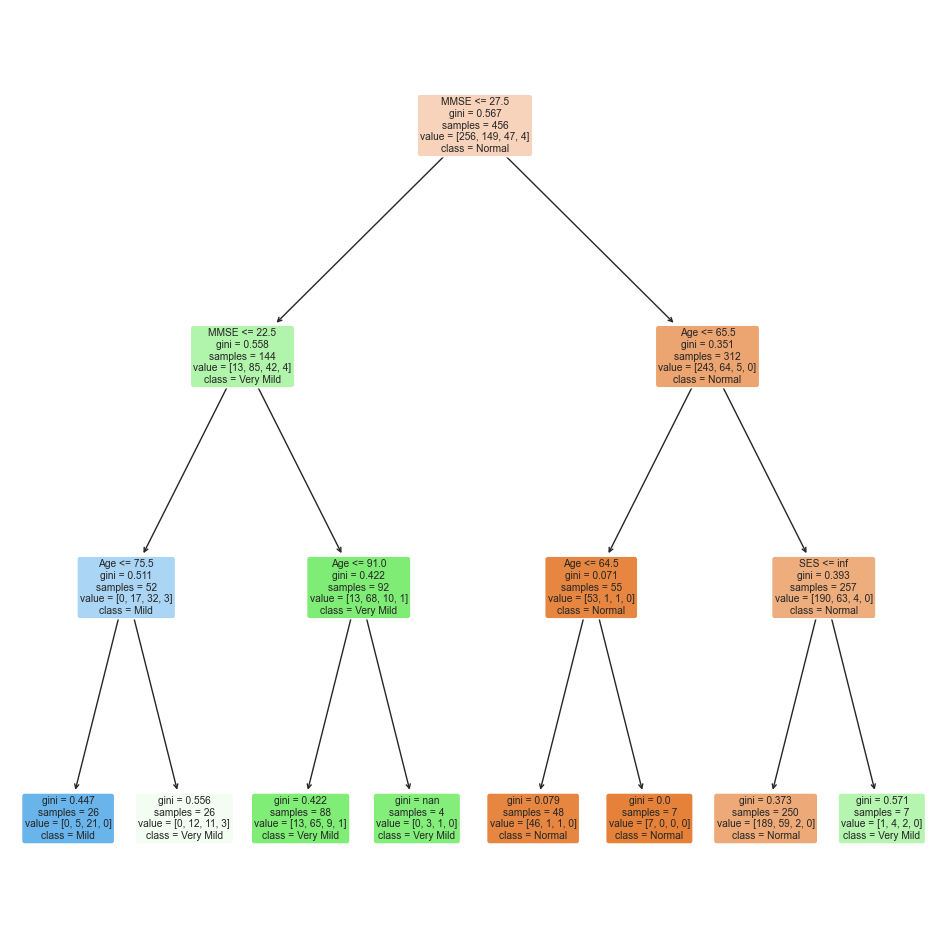

In [10]:
X_train3, X_test3, y_train3, y_test3, y_train_pred3, y_test_pred3, dectree3 = ClassificationTree(x, y, 3)

### Classification Tree Model of Max Depth 4

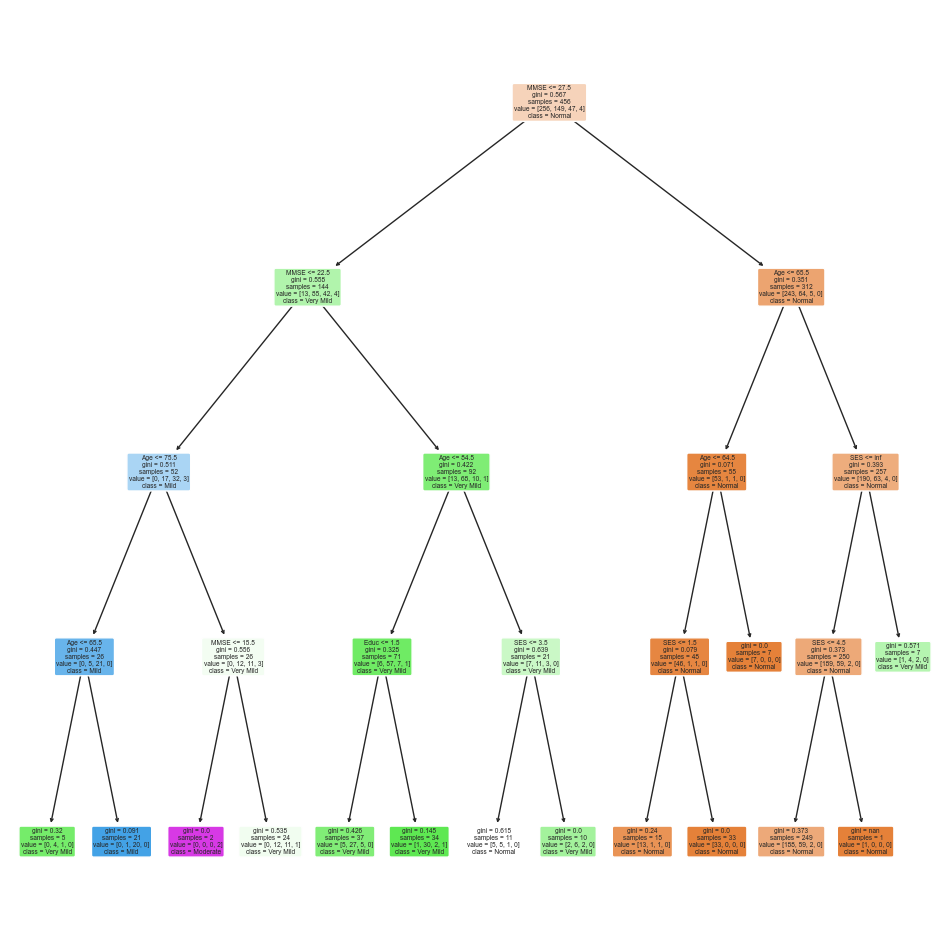

In [11]:
X_train4, X_test4, y_train4, y_test4, y_train_pred4, y_test_pred4, dectree4 = ClassificationTree (x, y, 4)

## Check the Accuracy of the Model

Print the Classification Accuracy and all other Accuracy Measures from the Confusion Matrix.  

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 

Again, a simple Python function can be written and called

In [12]:
def confusionmatrixValues(confusionmatrix):
    tn = confusionmatrix[0][0]
    fp = confusionmatrix[0][1]
    fn = confusionmatrix[1][0]
    tp = confusionmatrix[1][1]

    return tn, fp, fn, tp

def printConfusionMatrix(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred , dectree):
    
    confusionmatrix_train = confusion_matrix(y_train, y_train_pred)
    confusionmatrix_test = confusion_matrix(y_test, y_test_pred)

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusionmatrix_train,
            annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusionmatrix_test, 
            annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


    tn_train, fp_train, fn_train, tp_train = confusionmatrixValues(confusionmatrix_train)
    tn_test, fp_test, fn_test, tp_test = confusionmatrixValues(confusionmatrix_test)
    

    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", dectree.score(X_train, y_train))
    print("True Positive Rate (TPR) \t:", tp_train / (tp_train + fn_train))
    print("True Negative Rate (TNR) \t:", tn_train / (tn_train + fp_train))
    print()
    print("False Positive Rate (FPR) \t:", fp_train / (fp_train + tn_train))
    print("False Negative Rate (FNR) \t:", fn_train / (tp_train + fn_train))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", dectree.score(X_test, y_test))
    print("True Positive Rate (TPR) \t:", tp_train / (tp_train + fn_train))
    print("True Negative Rate (TNR) \t:", tn_train / (tn_train + fp_train))
    print()
    print("False Positive Rate (FPR) \t:", fp_train / (fp_train + tn_train))
    print("False Negative Rate (FNR) \t:", fn_train / (tp_train + fn_train))
    print()
    
    print()

    return

### Confusion Matrix for Classification Tree Model of Max Depth 3

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7609649122807017
True Positive Rate (TPR) 	: 0.5833333333333334
True Negative Rate (TNR) 	: 0.9453125

False Positive Rate (FPR) 	: 0.0546875
False Negative Rate (FNR) 	: 0.4166666666666667

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7236842105263158
True Positive Rate (TPR) 	: 0.5833333333333334
True Negative Rate (TNR) 	: 0.9453125

False Positive Rate (FPR) 	: 0.0546875
False Negative Rate (FNR) 	: 0.4166666666666667




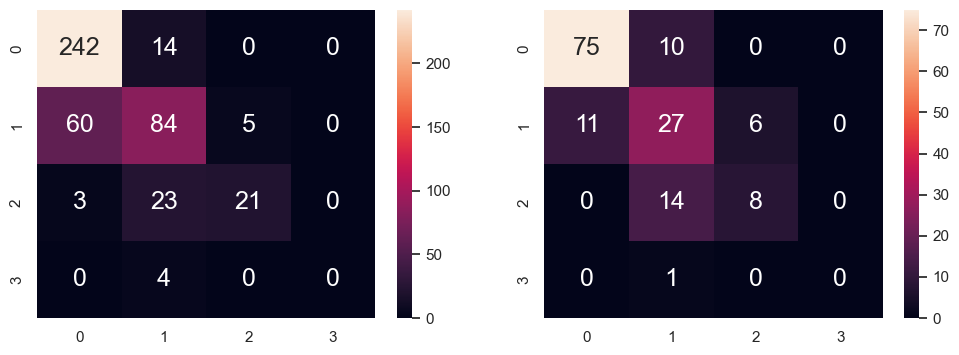

In [13]:
printConfusionMatrix(X_train3, X_test3, y_train3, y_test3, y_train_pred3, y_test_pred3, dectree3)

### Confusion Matrix for Classification Tree Model of Max Depth 4

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7719298245614035
True Positive Rate (TPR) 	: 0.5608108108108109
True Negative Rate (TNR) 	: 0.96484375

False Positive Rate (FPR) 	: 0.03515625
False Negative Rate (FNR) 	: 0.4391891891891892

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.75
True Positive Rate (TPR) 	: 0.5608108108108109
True Negative Rate (TNR) 	: 0.96484375

False Positive Rate (FPR) 	: 0.03515625
False Negative Rate (FNR) 	: 0.4391891891891892




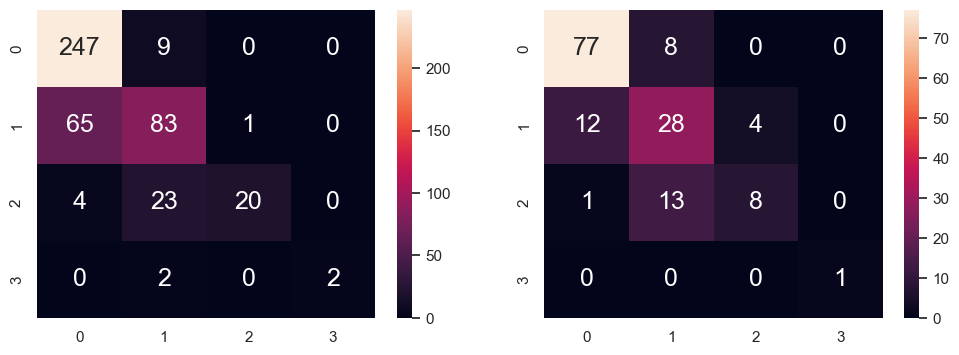

In [14]:
printConfusionMatrix(X_train4, X_test4, y_train4, y_test4, y_train_pred4, y_test_pred4, dectree4)

`Evaluation`: From our initial attempt in creating a model for 'CDR' it is evident that there is a huge discrepancy between the false positive and false negative rates. (HIGHLIGHT THE DISCREPENCY MORE SPECIFICALLY - use the figures)

---

# CREATING A MODEL FOR `CDR`: Attempt 2

Refine the previous model by balancing the classes of the response `CDR` in the training data. Keeping the OneHotEncoding same as before.

WHY IS THERE A NEED TO BALANCE?

In [15]:
from sklearn.utils import resample
import warnings

# Identify the different classes and their counts in the 'CDR' column
cdr_value_counts = alzheimersData['CDR'].value_counts()

# Find the majority class and its count
majority_class = cdr_value_counts.idxmax()
majority_class_count = cdr_value_counts.max()

# Split the dataset into subsets based on the value of the 'CDR' variable
subsets = {cdr_value: alzheimersData[alzheimersData['CDR'] == cdr_value] for cdr_value in cdr_value_counts.index}

# Upsample minority classes
upsampled_subsets = [subsets[majority_class]]  # start with the majority class

for cdr_value, subset in subsets.items():
    if cdr_value != majority_class:  # only upsample minority classes
        upsampled_subset = resample(subset,
                                    replace=True,
                                    n_samples=majority_class_count,  # match number in majority class
                                    random_state=42)  # reproducible results
        upsampled_subsets.append(upsampled_subset)

# Combine the upsampled classes with the majority class to form a balanced dataset
balanced_alzheimers_data = pd.concat(upsampled_subsets)

# Check the new value counts to ensure the classes are balanced
balanced_value_counts = balanced_alzheimers_data['CDR'].value_counts()
balanced_value_counts

CDR
0.0    341
0.5    341
1.0    341
2.0    341
Name: count, dtype: int64

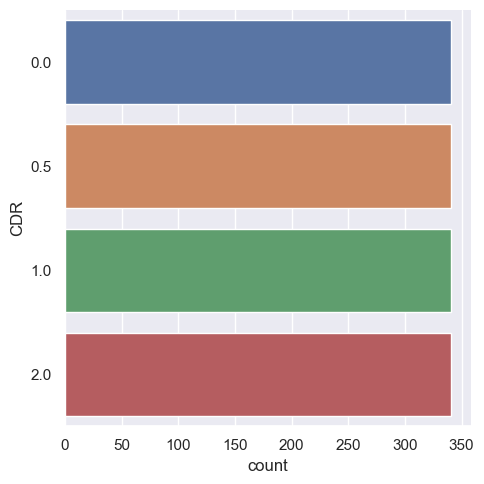

In [16]:
warnings.filterwarnings('ignore', message='The figure layout has changed to tight')

# Quick plot to check the balanced classes visually
sb.catplot(y = 'CDR', data = balanced_alzheimers_data, kind = "count")

In [17]:
# Confirm that the OHE is still in place
# and that the samples have now increased
balanced_alzheimers_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1364 entries, 0 to 159
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MRI ID  1364 non-null   object 
 1   M/F     1364 non-null   object 
 2   Age     1364 non-null   int64  
 3   Educ    1364 non-null   float64
 4   SES     1272 non-null   float64
 5   MMSE    1357 non-null   float64
 6   CDR     1364 non-null   float64
 7   eTIV    1364 non-null   int64  
 8   nWBV    1364 non-null   float64
 9   ASF     1364 non-null   float64
dtypes: float64(6), int64(2), object(2)
memory usage: 117.2+ KB


### Create and Fit the Model

After the encoding and upsampling is done, we can create and fit the `DecisionTreeClassifier` model on the dataset.

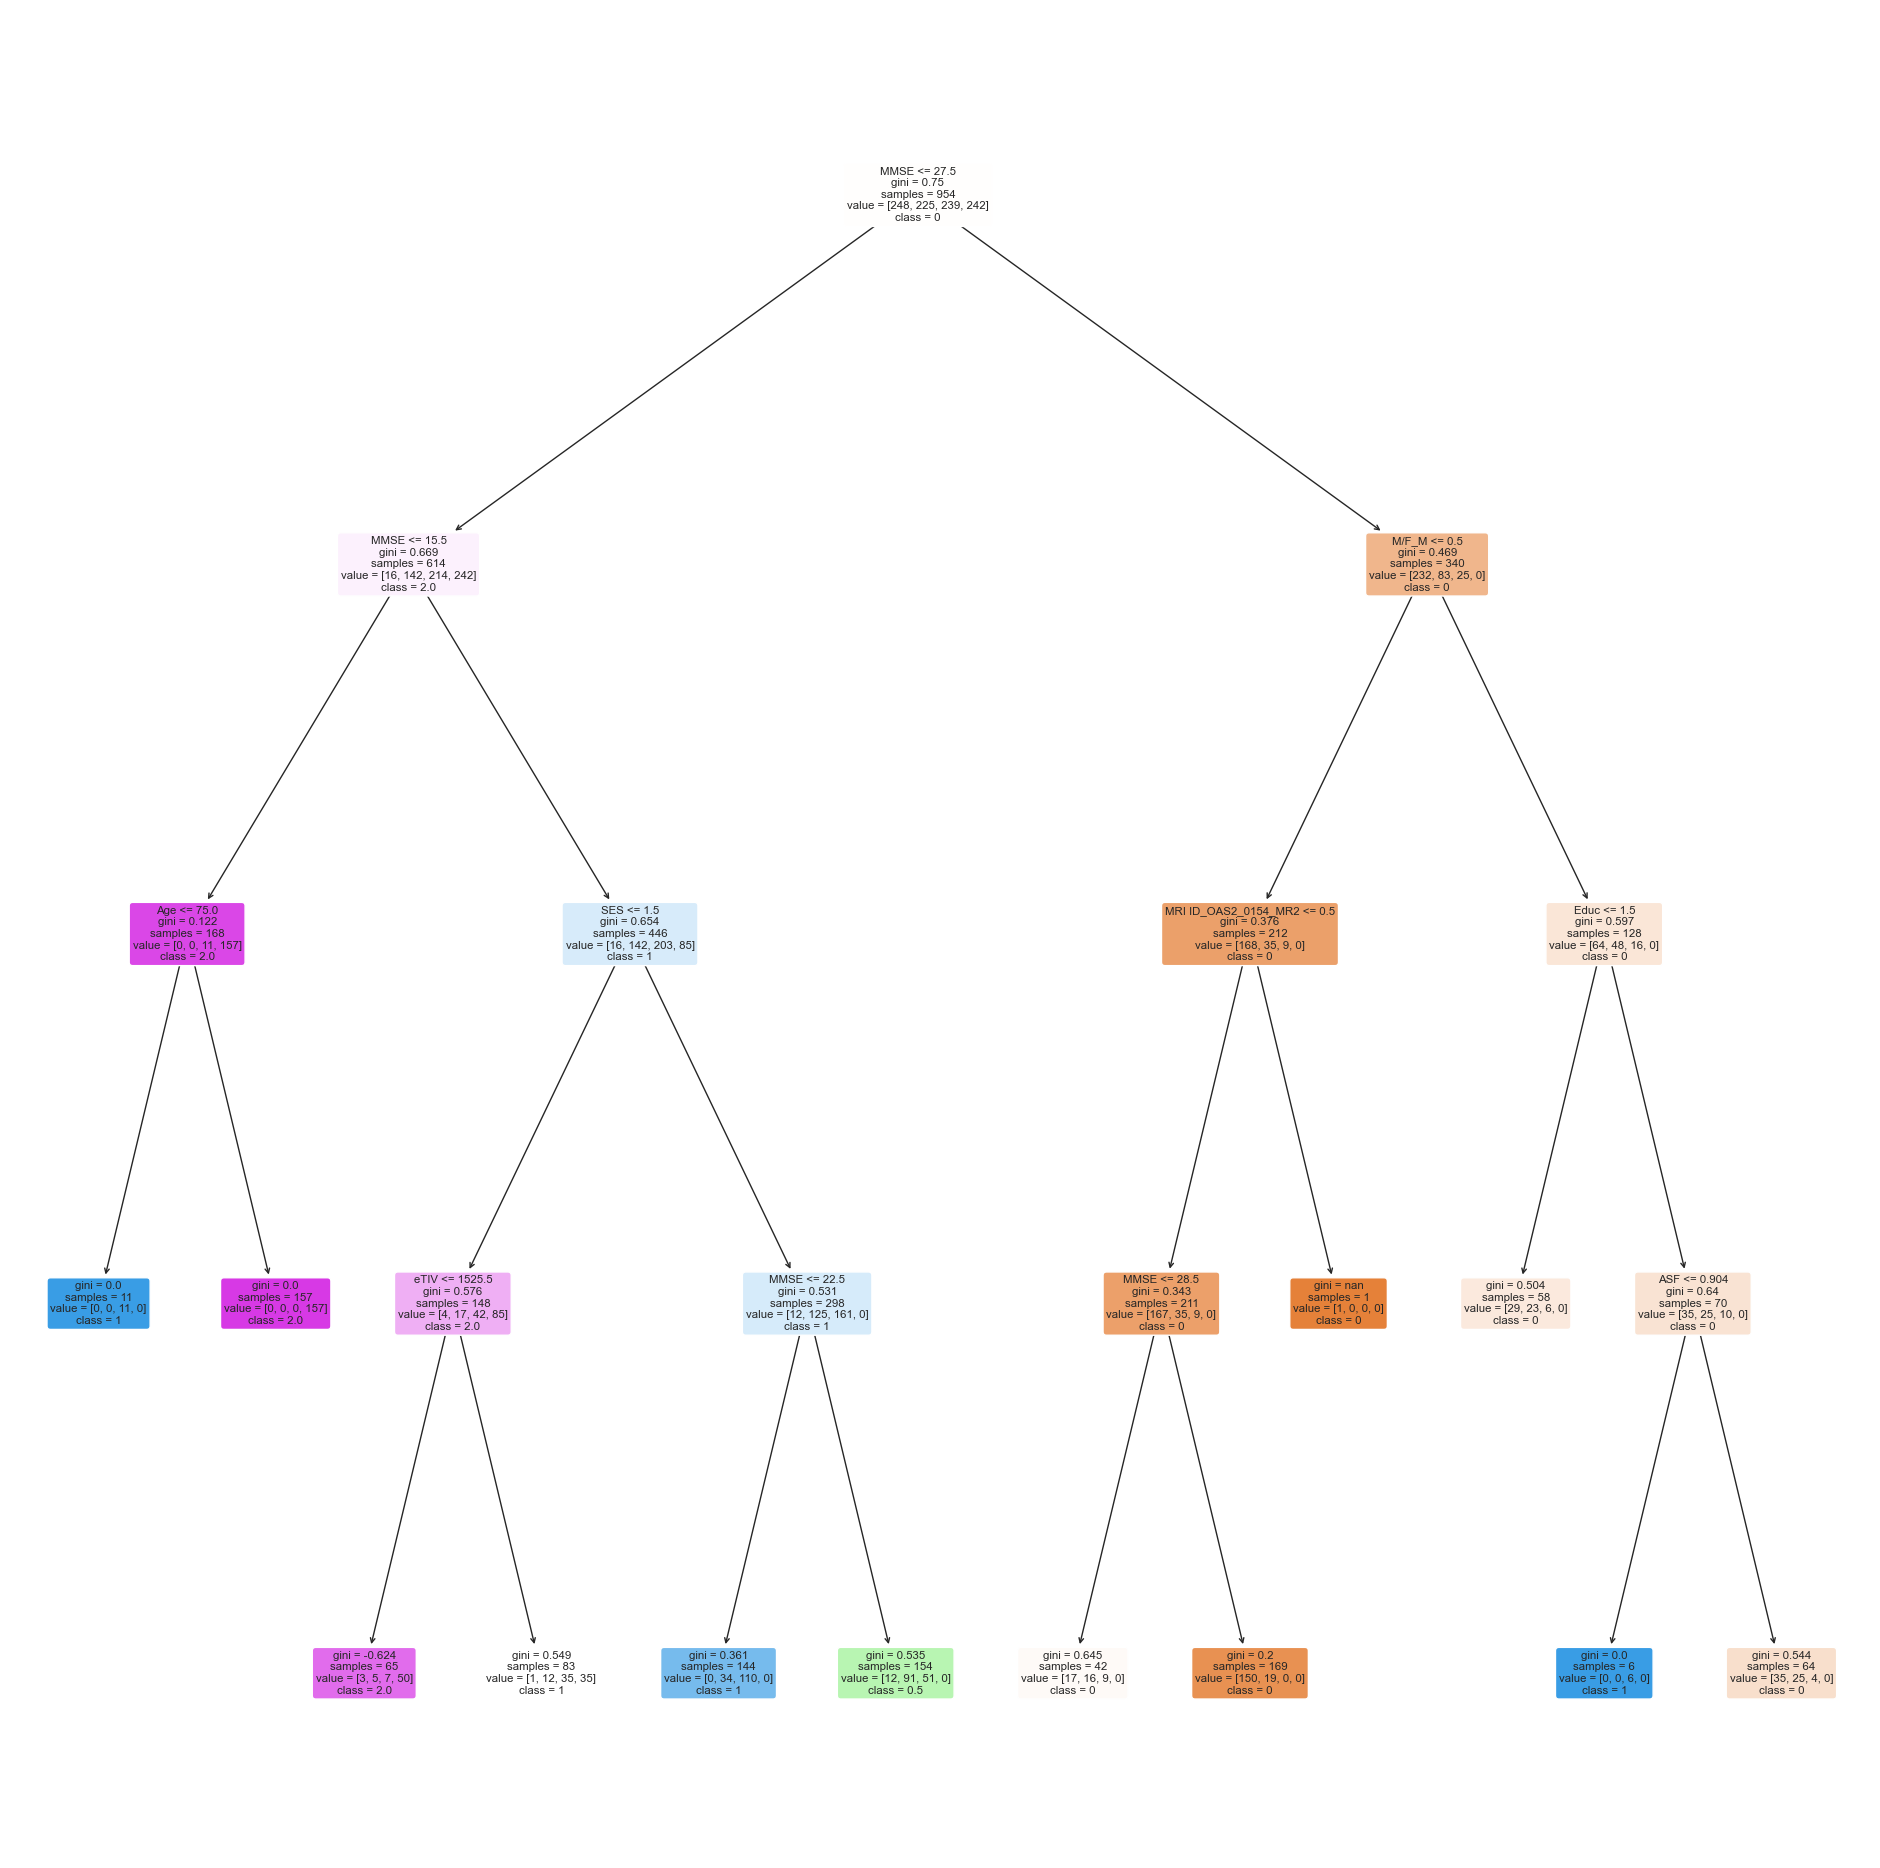

In [18]:
# Convert 'CDR' column to categorical and encode
balanced_alzheimers_data['CDR'] = pd.Categorical(balanced_alzheimers_data['CDR'])
balanced_alzheimers_data['CDR'] = balanced_alzheimers_data['CDR'].cat.codes

# Identify categorical columns (modify this list based on your actual categorical columns)
categorical_cols = balanced_alzheimers_data.select_dtypes(include=['object']).columns.tolist()

# One-hot encode categorical columns
balanced_alzheimers_data = pd.get_dummies(balanced_alzheimers_data, columns=categorical_cols)

# Split the Dataset into Train and Test
X = balanced_alzheimers_data.drop('CDR', axis=1)
y = balanced_alzheimers_data['CDR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth=4)
dectree.fit(X_train, y_train)

# Plot the trained Decision Tree
plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, feature_names=list(X_train.columns), class_names=["0","0.5","1","2.0"])
plt.show()


### Check the accuracy of the Model

Print the Classification Accuracy and all other Accuracy Measures from the Confusion Matrix.  

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 

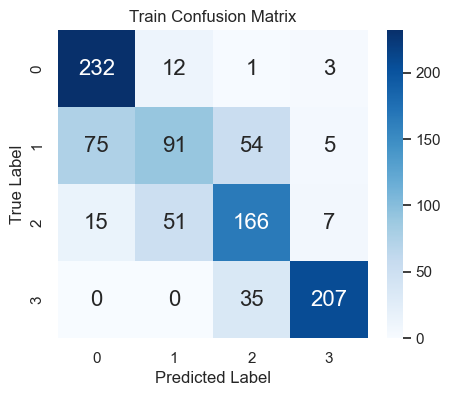

Train Data:
Accuracy: 0.7296
True Positive Rate: 0.5482
True Negative Rate: 0.9508


False Positive Rate: 0.0492
False Negative Rate: 0.4518


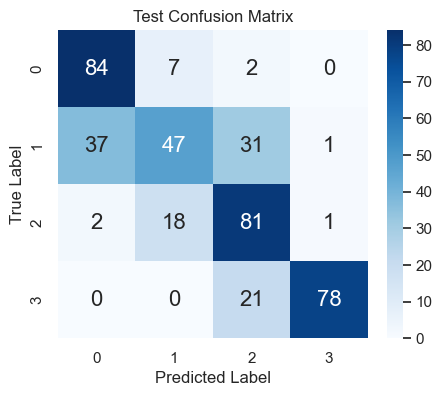

Test Data:
Accuracy: 0.7073
True Positive Rate: 0.5595
True Negative Rate: 0.9231


False Positive Rate: 0.0769
False Negative Rate: 0.4405


In [19]:
from sklearn.metrics import accuracy_score

def print_performance_metrics(y_true, y_pred, dataset_type):
    """ Prints the performance metrics for the provided dataset type (Train/Test). """
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (cm[0][0], cm[0][1], cm[1][0], cm[1][1])
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    fpr = fp / (tn + fp)
    fnr = fn / (tp + fn)

    # Plotting the confusion matrix
    plt.figure(figsize=(5, 4))
    sb.heatmap(cm, annot=True, fmt="d", cmap='Blues', annot_kws={"size": 16})
    plt.title(f'{dataset_type} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Printing metrics
    print(f"{dataset_type} Data:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"True Positive Rate: {tpr:.4f}")
    print(f"True Negative Rate: {tnr:.4f}")
    print("\n")
    print(f"False Positive Rate: {fpr:.4f}")
    print(f"False Negative Rate: {fnr:.4f}")

def evaluate_decision_tree():
    # Load and prepare data (assuming balanced_alzheimers_data is preloaded and 'CDR' is coded)
    X = balanced_alzheimers_data.drop('CDR', axis=1)
    y = balanced_alzheimers_data['CDR']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train the decision tree model
    dectree = DecisionTreeClassifier(max_depth=4)
    dectree.fit(X_train, y_train)

    # Prediction
    y_train_pred = dectree.predict(X_train)
    y_test_pred = dectree.predict(X_test)

    # Evaluate and print performance metrics for training data
    print_performance_metrics(y_train, y_train_pred, "Train")

    # Evaluate and print performance metrics for testing data
    print_performance_metrics(y_test, y_test_pred, "Test")

# Run the evaluation
evaluate_decision_tree()


`Evaluation`: We have managed to balance the false positives and false negatives rates, however the accuracy can still be improved. (IMPROVE FROM WHAT TO WHAT?)

---
# CREATING A MODEL FOR `CDR`: Attempt 3

From the second model it is obvious that the Decision Tree isn't achieving the highest accuracy even after upsampling and encoding. Hence, we have chosen to try another tree based classifier -- `RandomForest`. 

This was the most suitable model for our dataset due to its robustness to outliers and its ability to handle non-linear relationships, making it highly effective for complex datasets like Alzheimer's data with varied features

We have kept all the goodness of upsampling and encoding from our previous attempts, and thus, we will use the final dataset we created in the last attempt.

In [20]:
# Extract Response and Predictors
y = pd.DataFrame(balanced_alzheimers_data['CDR'])
X = pd.DataFrame(balanced_alzheimers_data.drop('CDR', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

It is important to note that for the rest of our analysis of the Alzheimer's dataset, we have opted to use `Median Imputation` for the X variables and `Most Frequent` imputation for the y variable. 

We chose median imputation for the X variables, specifically for MMSE and SES, due to their skewed distributions and potential outliers, ensuring a robust representation of central tendency. 

For the y variable (CDR), most frequent imputation was selected to preserve the modal class in this categorical outcome, reflecting the most common clinical state, and thereby maintaining the integrity of the dataset's distribution. 

This approach is preferable to removing data with missing values, as it preserves crucial information that would otherwise be lost. By imputing missing values, especially in significant columns, we maintain the dataset's predictive power, enhancing our model's ability to generate reliable insights.

In [21]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Handling missing values in X_train
imputer_X = SimpleImputer(missing_values=np.nan, strategy='median')  # Replace NaNs with the mean of columns in X_train
X_train_imputed = imputer_X.fit_transform(X_train)

# Handling missing values in y_train.Rating
imputer_y = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  # Replace NaNs with the most frequent values in y_train.Rating
y_train_imputed = imputer_y.fit_transform(y_train[['CDR']]).ravel()  # Ensure it is a 1D array for sklearn

# Creating the RandomForest object
rforest = RandomForestClassifier(n_estimators=100, max_depth=4)

# Fit RandomForest on the preprocessed Train Data
rforest.fit(X_train_imputed, y_train_imputed)


RandomForestClassifier(max_depth=4)

In [22]:
from sklearn.metrics import classification_report

def evaluate_model_performance(X, y, rforest, dataset_name="Train"):
    """
    Evaluates the performance of a trained RandomForest model on a given dataset.
    
    Parameters:
    - X: Features dataset (either X_train or X_test)
    - y: Target dataset (either y_train or y_test)
    - rforest: Trained RandomForest model
    - dataset_name: Label indicating whether the dataset is training or testing set
    """
    # Create an imputer object to fill missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Impute missing values in X
    X_imputed = imputer.fit_transform(X)
    
    # Predict the responses for the imputed data
    y_pred = rforest.predict(X_imputed)
    
    # Print the classification accuracy
    print(f"{dataset_name} Data")
    print("Accuracy  :\t", accuracy_score(y['CDR'].ravel(), y_pred))
    print()
    
    # Prepare y by ensuring it is correctly shaped for comparison
    y_processed = np.ravel(y[['CDR']])  # Ensure it is a 1D array for sklearn
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_processed, y_pred)
    tp = cm[1][1]  # True Positives
    fp = cm[0][1]  # False Positives
    tn = cm[0][0]  # True Negatives
    fn = cm[1][0]  # False Negatives
    
    # Print accuracy measures derived from the confusion matrix
    print("True Positive Rate (TPR) " + dataset_name + " :\t", (tp / (tp + fn)) if (tp + fn) != 0 else "N/A")
    print("True Negative Rate (TNR) " + dataset_name + " :\t", (tn / (tn + fp)) if (tn + fp) != 0 else "N/A")
    print()
    print("False Positive Rate (FPR) " + dataset_name + " :\t", (fp / (fp + tn)) if (fp + tn) != 0 else "N/A")
    print("False Negative Rate (FNR) " + dataset_name + " :\t", (fn / (fn + tp)) if (fn + tp) != 0 else "N/A")
    
    # Print a detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_processed, y_pred))
    
    # Plot the two-way confusion matrix
    plt.figure(figsize=(8, 6))
    sb.heatmap(cm, annot=True, fmt=".0f", annot_kws={"size": 18}, cmap='Blues')
    plt.title(f'Confusion Matrix for {dataset_name} Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Train Data
Accuracy  :	 0.7840670859538784

True Positive Rate (TPR) Train :	 0.7727272727272727
True Negative Rate (TNR) Train :	 0.8831168831168831

False Positive Rate (FPR) Train :	 0.11688311688311688
False Negative Rate (FNR) Train :	 0.22727272727272727

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       231
           1       0.71      0.66      0.69       257
           2       0.88      0.60      0.72       232
           3       0.79      1.00      0.88       234

    accuracy                           0.78       954
   macro avg       0.79      0.79      0.78       954
weighted avg       0.79      0.78      0.78       954



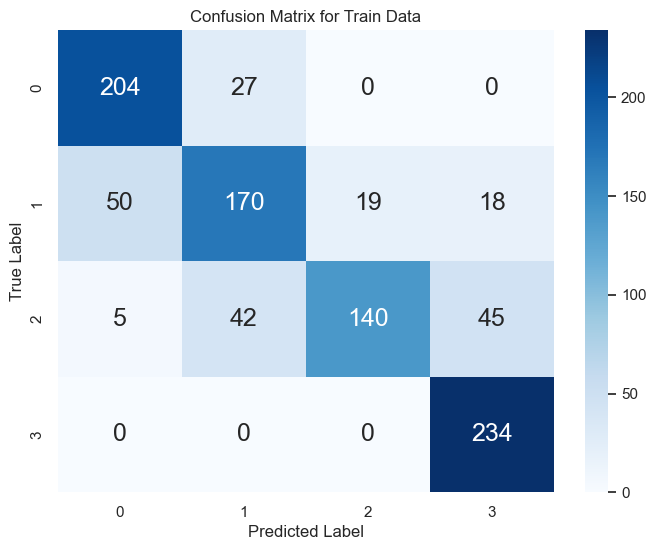

In [23]:
evaluate_model_performance(X_train, y_train, rforest, "Train")

Test Data
Accuracy  :	 0.7658536585365854

True Positive Rate (TPR) Test :	 0.7236842105263158
True Negative Rate (TNR) Test :	 0.8181818181818182

False Positive Rate (FPR) Test :	 0.18181818181818182
False Negative Rate (FNR) Test :	 0.27631578947368424

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       110
           1       0.55      0.65      0.60        84
           2       0.93      0.57      0.70       109
           3       0.84      1.00      0.91       107

    accuracy                           0.77       410
   macro avg       0.77      0.76      0.75       410
weighted avg       0.79      0.77      0.76       410



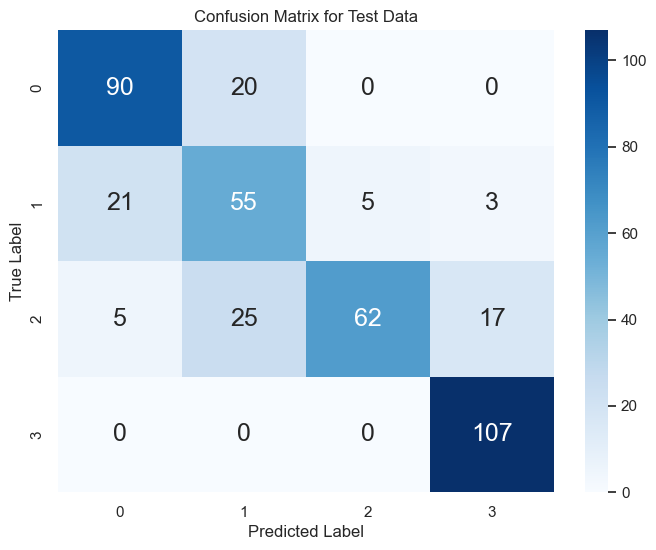

In [24]:
evaluate_model_performance(X_test, y_test, rforest, "Test")

### Increase the Number of Decision Trees in the Forest

In [25]:
y = pd.DataFrame(balanced_alzheimers_data['CDR'])
X = pd.DataFrame(balanced_alzheimers_data.drop('CDR', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Handling missing values in X_train
imputer_X = SimpleImputer(missing_values=np.nan, strategy='median')  # Replace NaNs with the mean of columns in X_train
X_train_imputed = imputer_X.fit_transform(X_train)

# Handling missing values in y_train.Rating
imputer_y = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  # Replace NaNs with the most frequent values in y_train.Rating
y_train_imputed = imputer_y.fit_transform(y_train[['CDR']]).ravel()  # Ensure it is a 1D array for sklearn

# Creating the RandomForest object
rforest = RandomForestClassifier(n_estimators=1000, max_depth=4) #changed to 1000 

# Fit RandomForest on the preprocessed Train Data
rforest.fit(X_train_imputed, y_train_imputed)

RandomForestClassifier(max_depth=4, n_estimators=1000)

Train Data
Accuracy  :	 0.8228511530398323

True Positive Rate (TPR) Train :	 0.5739644970414202
True Negative Rate (TNR) Train :	 0.9578059071729957

False Positive Rate (FPR) Train :	 0.04219409282700422
False Negative Rate (FNR) Train :	 0.4260355029585799

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.95      0.83       240
           1       0.84      0.41      0.56       234
           2       0.79      0.92      0.85       248
           3       0.97      1.00      0.99       232

    accuracy                           0.82       954
   macro avg       0.83      0.82      0.80       954
weighted avg       0.83      0.82      0.80       954



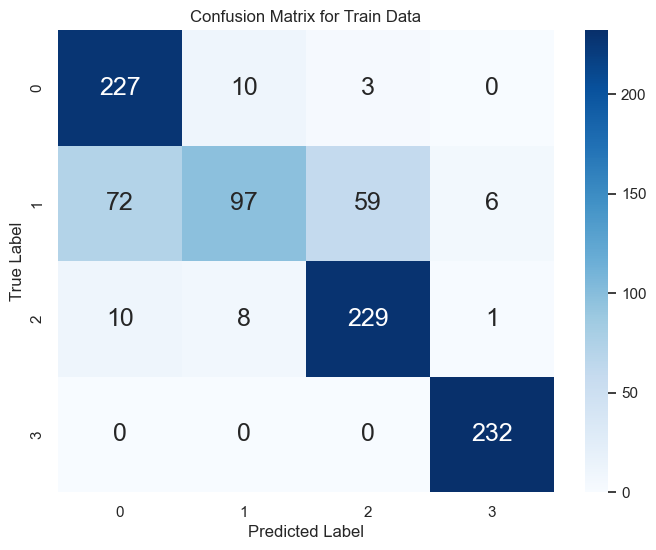

In [26]:
evaluate_model_performance(X_train, y_train, rforest, "Train")

Test Data
Accuracy  :	 0.7804878048780488

True Positive Rate (TPR) Test :	 0.43243243243243246
True Negative Rate (TNR) Test :	 0.96

False Positive Rate (FPR) Test :	 0.04
False Negative Rate (FNR) Test :	 0.5675675675675675

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.95      0.79       101
           1       0.84      0.30      0.44       107
           2       0.74      0.89      0.81        93
           3       0.92      1.00      0.96       109

    accuracy                           0.78       410
   macro avg       0.80      0.79      0.75       410
weighted avg       0.80      0.78      0.75       410



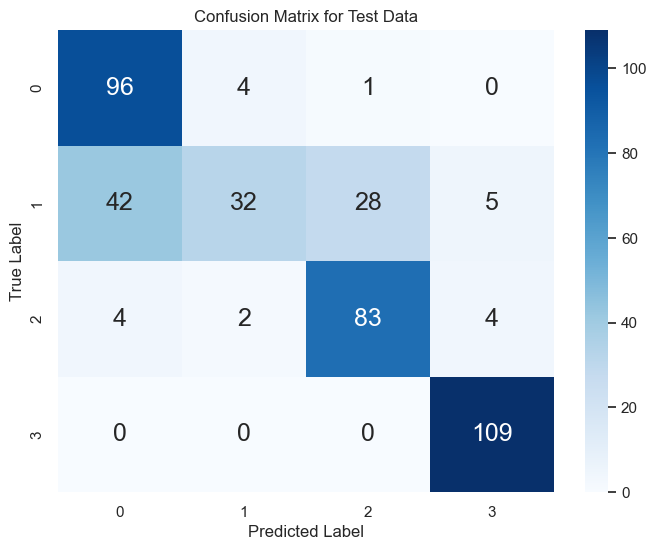

In [27]:
evaluate_model_performance(X_test, y_test, rforest, "Test")

### Increase the Depth of Decision Trees in the Forest

In [65]:
# Extract Response and Predictors
y = pd.DataFrame(balanced_alzheimers_data['CDR'])
X = pd.DataFrame(balanced_alzheimers_data.drop('CDR', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Handling missing values in X_train
imputer_X = SimpleImputer(missing_values=np.nan, strategy='median')  # Replace NaNs with the mean of columns in X_train
X_train_imputed = imputer_X.fit_transform(X_train)

# Handling missing values in y_train.Rating
imputer_y = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  # Replace NaNs with the most frequent values in y_train.Rating
y_train_imputed = imputer_y.fit_transform(y_train[['CDR']]).ravel()  # Ensure it is a 1D array for sklearn

# Creating the RandomForest object
rforest = RandomForestClassifier(n_estimators=100, max_depth=10) #changed to 10 (depth) 

# Fit RandomForest on the preprocessed Train Data
rforest.fit(X_train_imputed, y_train_imputed)


RandomForestClassifier(max_depth=10)

Train Data
Accuracy  :	 0.939203354297694

True Positive Rate (TPR) Train :	 0.880184331797235
True Negative Rate (TNR) Train :	 0.9708333333333333

False Positive Rate (FPR) Train :	 0.029166666666666667
False Negative Rate (FNR) Train :	 0.11981566820276497

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       241
           1       0.95      0.81      0.87       237
           2       0.92      0.98      0.95       251
           3       1.00      1.00      1.00       225

    accuracy                           0.94       954
   macro avg       0.94      0.94      0.94       954
weighted avg       0.94      0.94      0.94       954



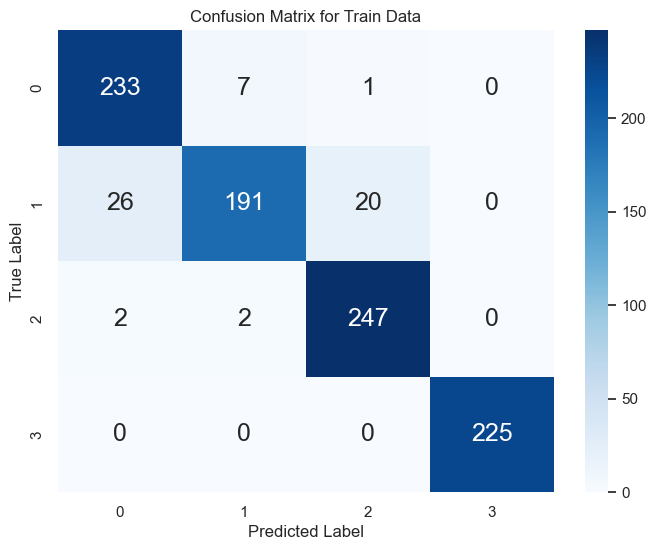

In [66]:
evaluate_model_performance(X_train, y_train, rforest, "Train")

Test Data
Accuracy  :	 0.8878048780487805

True Positive Rate (TPR) Test :	 0.7578947368421053
True Negative Rate (TNR) Test :	 0.89

False Positive Rate (FPR) Test :	 0.11
False Negative Rate (FNR) Test :	 0.24210526315789474

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       100
           1       0.85      0.69      0.76       104
           2       0.91      0.97      0.94        90
           3       1.00      1.00      1.00       116

    accuracy                           0.89       410
   macro avg       0.89      0.89      0.88       410
weighted avg       0.89      0.89      0.89       410



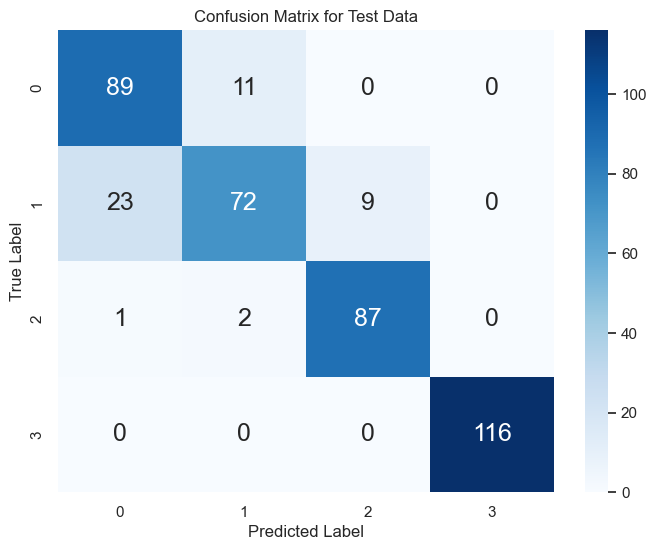

In [67]:
evaluate_model_performance(X_test, y_test, rforest, "Test")

### Increase both Number and Depth of Decision Trees in the Forest

In [60]:
# Extract Response and Predictors
y = pd.DataFrame(balanced_alzheimers_data['CDR'])
X = pd.DataFrame(balanced_alzheimers_data.drop('CDR', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Handling missing values in X_train
imputer_X = SimpleImputer(missing_values=np.nan, strategy='median')  # Replace NaNs with the mean of columns in X_train
X_train_imputed = imputer_X.fit_transform(X_train)

# Handling missing values in y_train.Rating
imputer_y = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  # Replace NaNs with the most frequent values in y_train.Rating
y_train_imputed = imputer_y.fit_transform(y_train[['CDR']]).ravel()  # Ensure it is a 1D array for sklearn

# Creating the RandomForest object
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10) #changed to 1000 and 10

# Fit RandomForest on the preprocessed Train Data
rforest.fit(X_train_imputed, y_train_imputed)


RandomForestClassifier(max_depth=10, n_estimators=1000)

Train Data
Accuracy  :	 0.9412997903563941

True Positive Rate (TPR) Train :	 0.8959276018099548
True Negative Rate (TNR) Train :	 0.9565217391304348

False Positive Rate (FPR) Train :	 0.043478260869565216
False Negative Rate (FNR) Train :	 0.10407239819004525

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       230
           1       0.93      0.83      0.88       238
           2       0.93      0.98      0.95       242
           3       1.00      1.00      1.00       244

    accuracy                           0.94       954
   macro avg       0.94      0.94      0.94       954
weighted avg       0.94      0.94      0.94       954



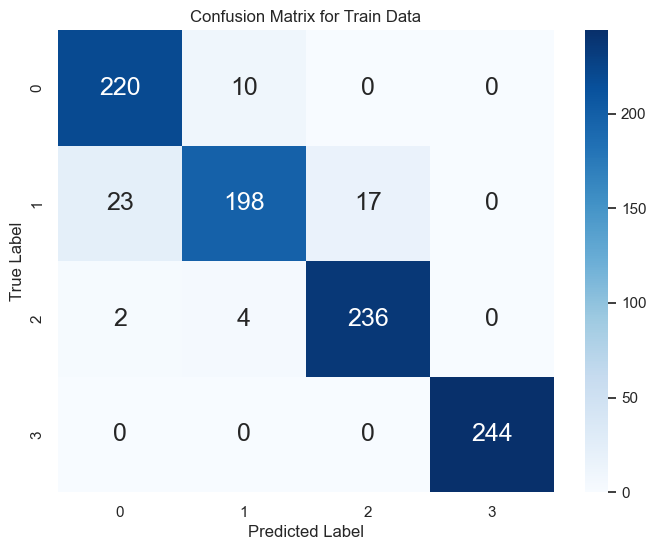

In [61]:
evaluate_model_performance(X_train, y_train, rforest, "Train")

Test Data
Accuracy  :	 0.8902439024390244

True Positive Rate (TPR) Test :	 0.8295454545454546
True Negative Rate (TNR) Test :	 0.9272727272727272

False Positive Rate (FPR) Test :	 0.07272727272727272
False Negative Rate (FNR) Test :	 0.17045454545454544

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       111
           1       0.85      0.71      0.77       103
           2       0.85      0.94      0.89        99
           3       1.00      1.00      1.00        97

    accuracy                           0.89       410
   macro avg       0.89      0.89      0.89       410
weighted avg       0.89      0.89      0.89       410



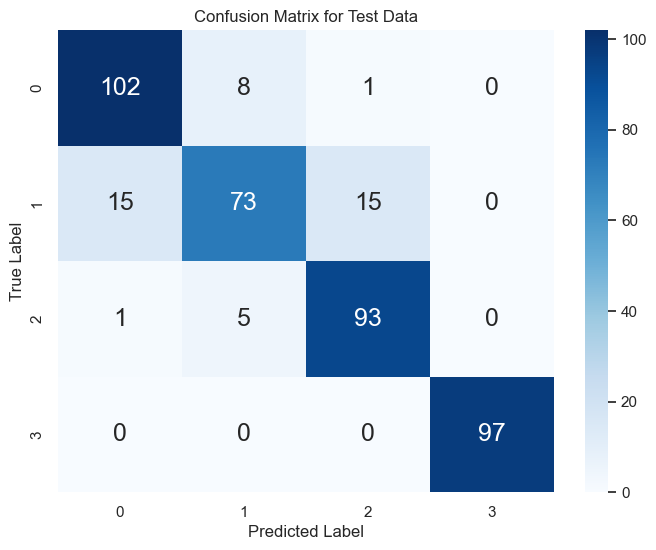

In [64]:
evaluate_model_performance(X_test, y_test, rforest, "Test")

`Evaluation`: We can see that with more number of trees and deeper trees in the forest, the accuracy of the Random Forest is getting better on both the train and test sets, but the gap between the performance on train and test is increasing too. This may be an indication of overfitting the train set.      

AGAIN, NEED FIGURES TO SHOW THE IMPROVE IN ACCURACY


---
# CREATING A MODEL FOR `CDR`: Attempt 4

For Attempt 4, we have opted to employ a basic set of tools of Cross-Validation tools to tune the Hyper-parameters of our Random Forest model. Our goal is to identify the ideal hyper-parameters that enhance the classifier's accuracy on the test set overall.

We have chosen to use the `accuracy metric`  because it is a direct measurement and provides a single figure that summarizes the overall effectiveness of the model across all categories of CDR (0, 0.5, 1.0, 2.0). In datasets where the classes are equally represented, accuracy serves as a robust and straightforward measure of model performance, providing a clear picture of how often the model predicts correctly across both classes. 

This metric simplifies the evaluation process, making it highly suitable for scenarios where stakeholders prefer easily interpretable results. Additionally, accuracy ensures that the model's effectiveness in distinguishing between different stages of Alzheimer’s disease (as represented by the CDR values) can be directly assessed, making it an ideal choice for this particular analysis

In [43]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Prepare response (y) and predictors (X)
y = pd.DataFrame(balanced_alzheimers_data['CDR'])
X = pd.DataFrame(balanced_alzheimers_data.drop('CDR', axis=1))

# Split the data
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Define a smaller hyperparameter grid
param_grid = {
    'n_estimators': np.arange(100,1001,100),  # fewer options
    'max_depth': np.arange(2, 11)
}

# Use RandomizedSearchCV to reduce the number of iterations
hpGrid = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_grid,
    n_iter=5,  # number of parameter settings sampled
    cv=3,  # fewer folds
    scoring='accuracy',
    n_jobs=-1  # use all CPU cores
)

# Train models using cross-validation
hpGrid.fit(X_train_imputed, y_train.values.ravel())

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
                   scoring='accuracy')

By using randomized search CV it will help in systematically test out different combinations of parametrs to find the bst fit based on model performance metrics such as 'accuracy'

In [44]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

RandomForestClassifier(max_depth=10, n_estimators=200)
0.8658280922431866


In [45]:
# Output the best model parameters and its accuracy
print("Best Parameters:", hpGrid.best_params_)
print("Best Model:", hpGrid.best_estimator_)

Best Parameters: {'n_estimators': 200, 'max_depth': 10}
Best Model: RandomForestClassifier(max_depth=10, n_estimators=200)


### Use the Best Model found through GridSearchCV

In [58]:
# Extract Response and Predictors
y = pd.DataFrame(balanced_alzheimers_data['CDR'])
X = pd.DataFrame(balanced_alzheimers_data.drop('CDR', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Fit on the training data and transform it
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Create the Random Forest object with optimal parameters
rforest = RandomForestClassifier(n_estimators = 200, max_depth = 10)

# Fit Random Forest on the imputed Train Data
rforest.fit(X_train_imputed, y_train.CDR.ravel())


RandomForestClassifier(max_depth=10, n_estimators=200)

Train Data
Accuracy  :	 0.9454926624737946

True Positive Rate (TPR) Train :	 0.8440366972477065
True Negative Rate (TNR) Train :	 0.9841269841269841

False Positive Rate (FPR) Train :	 0.015873015873015872
False Negative Rate (FNR) Train :	 0.1559633027522936

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       252
           1       0.97      0.80      0.88       229
           2       0.96      0.99      0.97       239
           3       1.00      1.00      1.00       234

    accuracy                           0.95       954
   macro avg       0.95      0.94      0.94       954
weighted avg       0.95      0.95      0.94       954



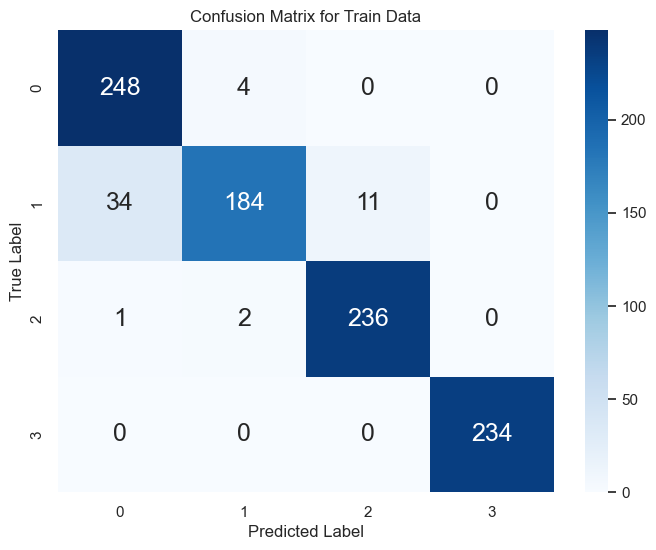

In [54]:
evaluate_model_performance(X_train, y_train, rforest, "Train")

Test Data
Accuracy  :	 0.8878048780487805

True Positive Rate (TPR) Test :	 0.7473684210526316
True Negative Rate (TNR) Test :	 0.9223300970873787

False Positive Rate (FPR) Test :	 0.07766990291262135
False Negative Rate (FNR) Test :	 0.25263157894736843

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       103
           1       0.84      0.70      0.76       102
           2       0.92      0.92      0.92        90
           3       1.00      1.00      1.00       115

    accuracy                           0.89       410
   macro avg       0.89      0.89      0.88       410
weighted avg       0.89      0.89      0.89       410



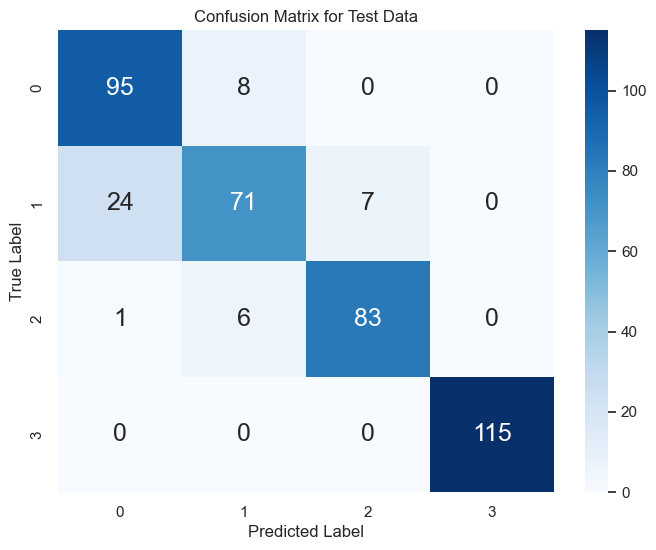

In [59]:
evaluate_model_performance(X_test, y_test, rforest, "Test")

COMMENTS?